In [1]:
# import packages
from keras.layers import Input, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# visualization
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

def myscatter(Y, class_idxs, legend=False, ran=True, seed=229):
    if ran:
        np.random.seed(seed)
    Y = np.array(Y)
    fig, ax = plt.subplots(figsize=(6,4), dpi=300)
    classes = list(np.unique(class_idxs))
    markers = 'osD' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    if ran:
        np.random.shuffle(colors)

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(Y[class_idxs == cls, 0], Y[class_idxs == cls, 1], marker=mark,
                linestyle='', ms=4, label=str(cls), alpha=1, color=colors[i],
                markeredgecolor='black', markeredgewidth=0.15)
    if legend:
        ax.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0, fontsize=10, markerscale=2, frameon=False,
                  ncol=2, handletextpad=0.1, columnspacing=0.5)

    plt.xticks([])
    plt.yticks([])

    return ax

In [3]:
# t-SNE
def tsne(X, dim=2, ran=23):
    t_sne = TSNE(n_components=dim, random_state=ran)
    Y_tsne = t_sne.fit_transform(X)
    return Y_tsne

In [32]:
# clustering layer

from tensorflow.keras import activations, constraints, initializers, regularizers
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow.keras.backend as K
import phenograph
from sklearn.cluster import KMeans

class ClusteringLayer(Layer):
    def __init__(self, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=None, initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def target_distribution(q):
    q = q.numpy()
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

def computeCentroids(data, labels):
    n_clusters = len(np.unique(labels))
    return np.array([data[labels == i].mean(0) for i in range(n_clusters)])

def get_centers(H, mode="kmeans", n_cluster=10):
    if mode == "louvain":
        l, _,  _ = phenograph.cluster(H)
    elif mode == "kmeans":
        l = KMeans(n_clusters=n_cluster, random_state=0).fit(h).labels_
    centers = computeCentroids(H, l)
    return centers, l

In [19]:
# read data
cells = np.array(pd.read_csv("colon_cell_info.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("colon_normalize.csv", index_col=0, sep=","))

In [5]:
# read data
cells = np.array(pd.read_csv("idents3_raw.csv", index_col=0, sep="\t"))
count = np.array(pd.read_csv("data3_raw.csv", index_col=0, sep="\t"))

In [20]:
# preprocessing
[n_sample, n_gene] = count.shape
cells = cells.flatten()
x_train = count.astype('float32')

In [132]:
from tensorflow.keras.losses import MSE, KLD
from keras.constraints import NonNeg
class AE(tf.keras.Model):

    def __init__(self, X, hidden_dim=256, latent_dim=50, impute_dim=64):
        super(AE, self).__init__()
        self.X = X

        # encoder
        encoder_in = Input(shape=n_gene)
        encoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(encoder_in)
        encoded2 = Dense(latent_dim, activation = "relu", use_bias=True)(encoded1)
        encoder = Model(inputs=encoder_in, outputs=encoded2, name="encoder")
    
        self.encoder = encoder
    
        # decoder
        decoder_in = Input(shape=latent_dim)
        decoded1 = Dense(hidden_dim, activation = "relu", use_bias=True)(decoder_in)
        decoded2 = Dense(n_gene, activation = "relu", use_bias=True)(decoded1)
        decoder = Model(inputs=decoder_in, outputs=decoded2, name="decoder")
    
        self.decoder = decoder
    
        # imputer
        impute_in = Input(shape=n_gene)
        imputed1 = Dense(impute_dim, activation = "relu")(impute_in)
        imputed2 = Dense(n_gene, activation = "relu")(imputed1)
        imputer = Model(inputs=impute_in, outputs=imputed2, name="imputer")
    
        impute_mask = np.zeros([n_sample, n_gene])
        for i in range(n_sample):
            for j in range(n_gene):
                if count[i,j] == 0:
                    impute_mask[i,j] = 1
        self.mask = tf.convert_to_tensor(impute_mask, dtype=tf.float32)
    
        self.imputer = imputer
    
        # clustering
        clustering_layer = ClusteringLayer(name='clustering')(encoded2)
        clustering_model = Model(inputs=encoder_in, outputs=clustering_layer, name="cluster")
    
        self.clustering = clustering_model
    
    # pre-training
    def train(self, T=2, max_epoch=100, learning_rate=0.0001):
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
        for epoch in range(1, max_epoch+1):
            with tf.GradientTape(persistent=True) as tape:
                
                x = self.X
                loss = 0
                
                for t in range(T):
                    h = self.encoder(x)
                    y = self.decoder(h)
                    
                    v = self.imputer(y)
                    x = self.X + tf.multiply(self.mask, v)
                    
                    loss += tf.reduce_mean(MSE(self.X, y))

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 10 == 0:
                print(loss)
        print("Finish!")
        
    # clustering training
    def clustering_train(self, h, wl=0.2, wc=0.8, max_epoch=30, learning_rate=0.0001, mode="kmeans", n_cluster=10):
        
        centers, labels = get_centers(np.array(h), mode=mode, n_cluster=n_cluster)
        self.clustering.get_layer(name='clustering').clusters = centers
        
        q = self.clustering(x_train)
        p = target_distribution(q)
        
        optimizer = tf.keras.optimizers.Adam()
        for epoch in range(1, max_epoch+1):
            if epoch % 10 == 0:
                #centers, labels = get_centers(np.array(h), mode=mode, n_cluster=n_cluster)
                #self.clustering.get_layer(name='clustering').clusters = centers
                q = self.clustering(self.X)
                p = target_distribution(q)
            with tf.GradientTape(persistent=True) as tape:
                
                h = self.encoder(x_train)
                y = self.decoder(h)
                    
                loss = tf.reduce_mean(MSE(self.X, y))
                
                q_out = self.clustering(self.X)
                
                cluster_loss = tf.reduce_mean(KLD(q_out, p))
                loss = wl * loss + wc * cluster_loss

            vars = self.trainable_weights
            grads = tape.gradient(loss, vars)
            optimizer.apply_gradients(zip(grads, vars))
            if epoch % 10 == 0:
                print(loss)
        print("Finish!")

In [133]:
autoencoder = AE(x_train, hidden_dim=512, latent_dim=50, impute_dim=64)

In [134]:
autoencoder.train(T=2, max_epoch=80)

/Users/chentaiyang/opt/anaconda3/envs/CompBio/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


tf.Tensor(180.90216, shape=(), dtype=float32)
tf.Tensor(171.96312, shape=(), dtype=float32)
tf.Tensor(153.71274, shape=(), dtype=float32)
tf.Tensor(126.16341, shape=(), dtype=float32)
tf.Tensor(102.9989, shape=(), dtype=float32)
tf.Tensor(87.83236, shape=(), dtype=float32)
tf.Tensor(78.25931, shape=(), dtype=float32)
tf.Tensor(71.67455, shape=(), dtype=float32)
Finish!


In [135]:
h = autoencoder.encoder(x_train)

In [136]:
ed = tsne(h)

<AxesSubplot:>

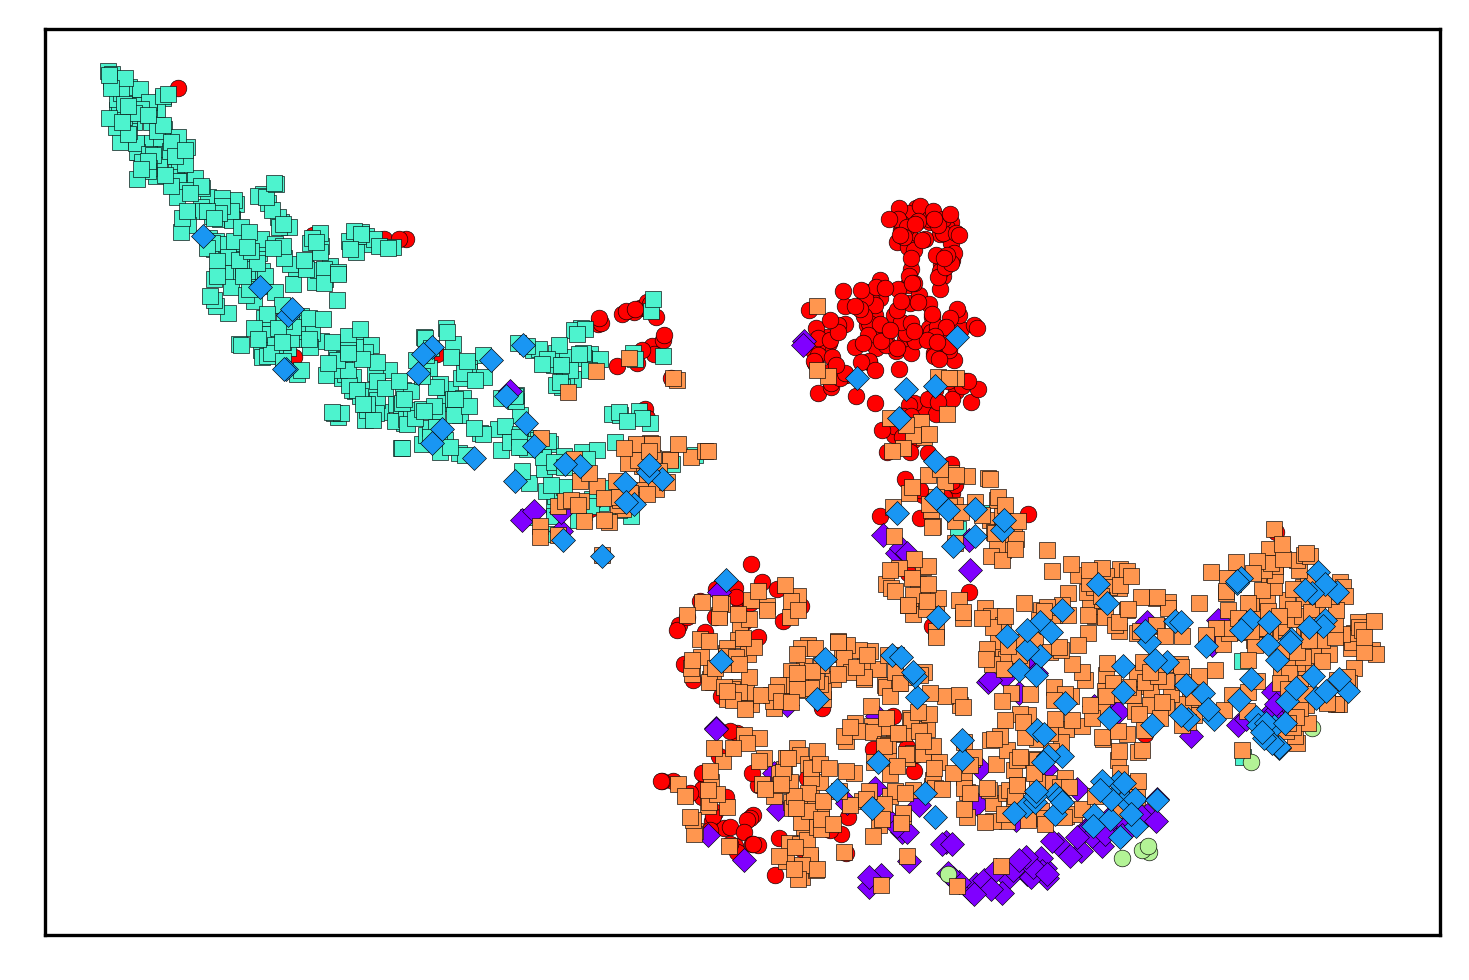

In [137]:
myscatter(ed, cells)

In [138]:
autoencoder.clustering_train(h, wl=0.5, wc=0.5, n_cluster=5, mode="kmeans", max_epoch=40)

tf.Tensor(13.441171, shape=(), dtype=float32)
tf.Tensor(6.1669984, shape=(), dtype=float32)
tf.Tensor(3.8006203, shape=(), dtype=float32)
tf.Tensor(3.1399693, shape=(), dtype=float32)
Finish!


In [139]:
h = autoencoder.encoder(x_train)

In [140]:
ed = tsne(h)

<AxesSubplot:>

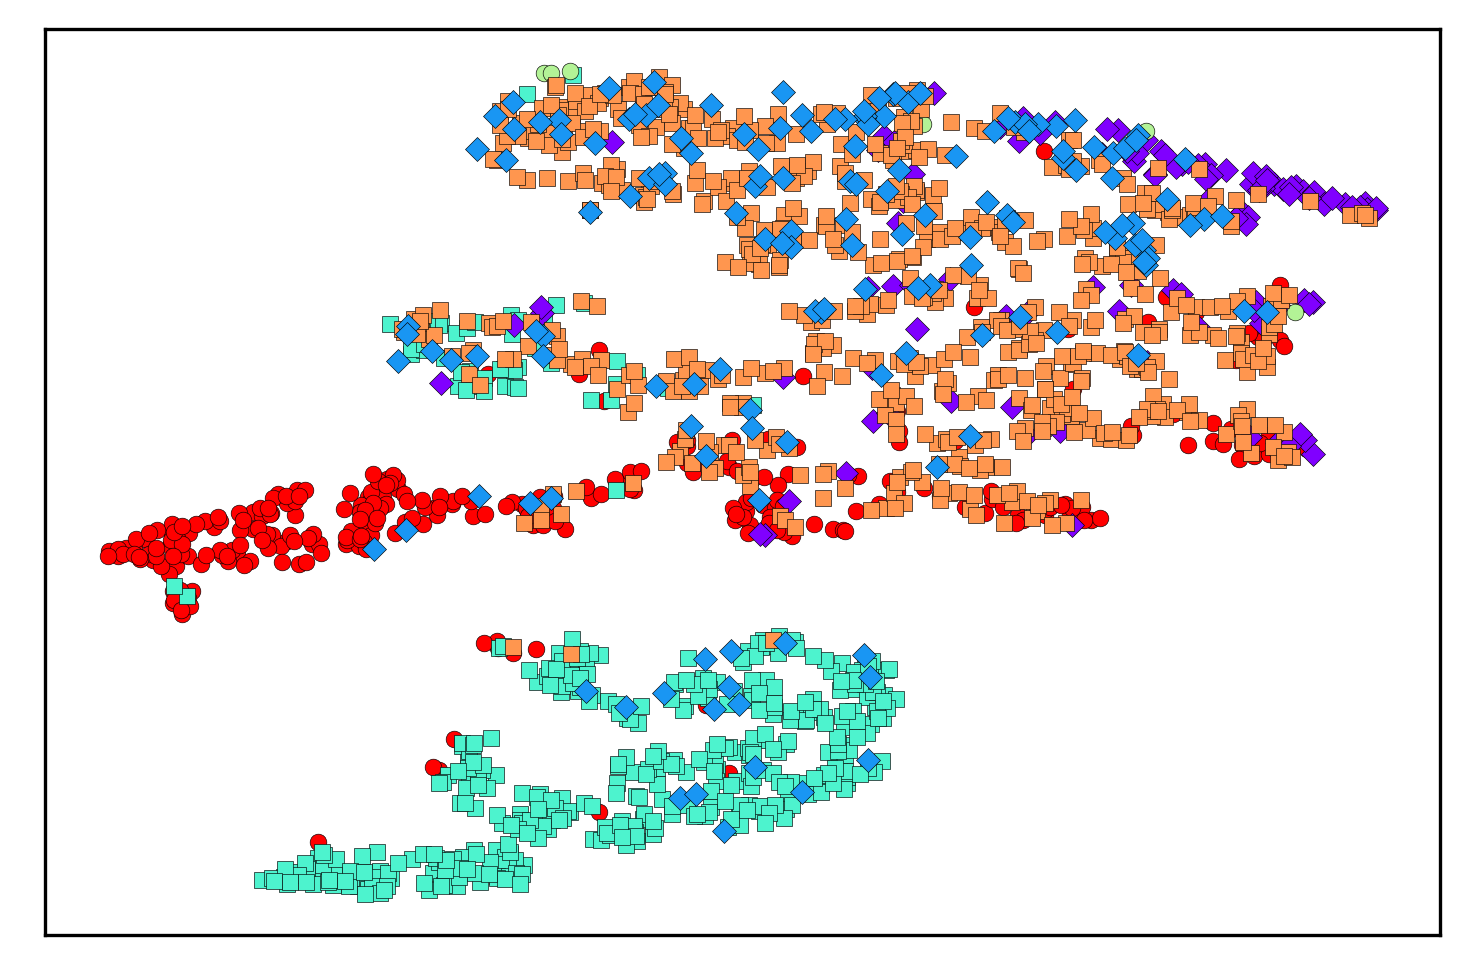

In [141]:
myscatter(ed, cells)

In [90]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, homogeneity_score, completeness_score
def measure(true, pred):
    NMI = round(normalized_mutual_info_score(true, pred), 2)
    RAND = round(adjusted_rand_score(true, pred), 2)
    HOMO = round(homogeneity_score(true, pred), 2)
    COMP = round(completeness_score(true, pred), 2)
    return [NMI, RAND, HOMO, COMP]

In [91]:
labels, _,  _ = phenograph.cluster(np.array(h))
measure(cells, labels)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.16079187393188477 seconds
Jaccard graph constructed in 2.4725558757781982 seconds
Wrote graph to binary file in 0.03956127166748047 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.821342
After 2 runs, maximum modularity is Q = 0.824694
Louvain completed 22 runs in 1.0179271697998047 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 4.856101989746094 seconds


[0.38, 0.2, 0.52, 0.3]

In [ ]:
myscatter(ed,labels)